# Задача 1

Прочитайте базу "Потребление Энергии" (или BRENT(сделать анализ пропусков и больше чем 2-х дневные заполнить, и работаем для 3-х дневного ресемплинга), или COVID-19(выбрать любую страну кроме Бразилии)) и сделайте модель основных изменений по data_exp_1(сглаженной) с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [4]:
def read_series(fileName="time_series_covid19_recovered_global.csv", CountryName='Brazil',Province=[], timePeriodStart='01.01.2020', timePeriodEnd='28.07.2020'):
    #fileName - откуда читаем
    # CountryName - какую страну читаем
    # timePeriodStart, timePeriodEnd - от какой до какой даты читаем
    COVID_d = pd.read_csv(fileName)
    #print(COVID_d.tail(20))
    if len(Province)>0:
        COVID_d = COVID_d.loc[(COVID_d['Country/Region']==CountryName)&(COVID_d['Province/State'].isin(Province))]
    else:
        COVID_d = COVID_d.loc[(COVID_d['Country/Region']==CountryName)]
    return COVID_d

In [2]:
def read_table(fileName=['time_series_covid19_deaths_global.csv','time_series_covid19_confirmed_global.csv','time_series_covid19_recovered_global.csv'], CountryName='Russia',Province=[],prov_Numb=[0], timePeriodStart='01.01.2020', timePeriodEnd='30.07.2020'):
    print(fileName[0])
    C2 = read_series(fileName='data/' + fileName[0], CountryName=CountryName,Province=Province, timePeriodStart=timePeriodStart, timePeriodEnd= timePeriodEnd)
    C1 = read_series(fileName='data/' +fileName[1], CountryName=CountryName,Province=Province, timePeriodStart=timePeriodStart, timePeriodEnd= timePeriodEnd)
    C3 = read_series(fileName='data/' +fileName[2], CountryName=CountryName,Province=Province, timePeriodStart=timePeriodStart, timePeriodEnd= timePeriodEnd)
    if len(prov_Numb)>1:
        Covid_data=C1.iloc[prov_Numb,4:].values.sum(axis=1).reshape((-1,1))
        Covid_data=np.hstack([Covid_data, C2.iloc[prov_Numb,4:].values.sum(axis=1).reshape((-1,1))])
        Covid_data=np.hstack([Covid_data, C3.iloc[prov_Numb,4:].values.sum(axis=1).reshape((-1,1))])
    else:    
        Covid_data=C1.iloc[prov_Numb,4:].values.reshape((-1,1))
        Covid_data=np.hstack([Covid_data, C2.iloc[prov_Numb,4:].values.reshape((-1,1))])
        Covid_data=np.hstack( [Covid_data,C3.iloc[prov_Numb,4:].values.reshape((-1,1))])
    print(Covid_data.shape)
    date = pd.to_datetime(C1.columns[4:])
    COVID_=pd.DataFrame(data=Covid_data,index=date, columns=['Confirmed','Deaths','Recovered'])
    #Нарисуем 
    COVID_.plot()
    plt.show()
    return  COVID_

time_series_covid19_deaths_global.csv
(191, 3)


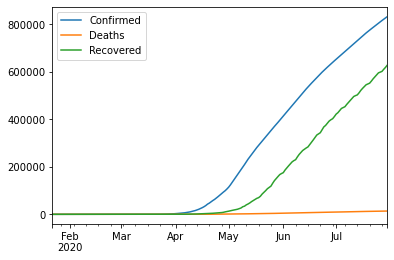

In [5]:
COVID_ = read_table()

## Видно, что Recovery ненамного просидает в неких точках. Рассмотрим это подробней после 

In [6]:
COVID_.head()

,Confirmed,Deaths,Recovered
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,0,0,0
2020-01-25,0,0,0
2020-01-26,0,0,0


Проверим на наличие дубликатов  

In [7]:
COVID_.index.duplicated().sum()

0

Как видим, дубликатов нет

Проверим на пропущенные значения

## Удалим хвост, где не было никаких наблюдений. Он нам не интересен 

Возмем за старт дату, когда число подвежденных случаев стало больше 100

In [10]:
ind_start = np.where(COVID_.loc[:,'Confirmed'].values>100)[0]
ind_start[0]

55

In [11]:
COVID_=COVID_.iloc[ind_start[0]:,:]

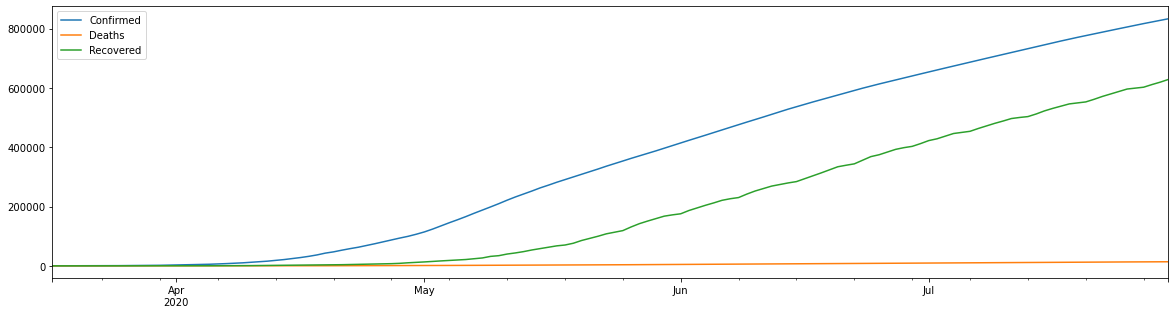

In [49]:
COVID_.plot(figsize=(20, 5))
plt.show()

Описательная статистика 

In [12]:
COVID_.describe()

,Confirmed,Deaths,Recovered
count,136.000000,136.000000,136.000000
mean,352136.125000,4855.117647,198376.110294
std,288487.626611,4589.031700,211400.538729
min,114.000000,0.000000,8.000000
25%,46054.000000,394.000000,3407.250000
50%,340181.500000,3464.500000,110617.500000
75%,621646.750000,8817.000000,385818.750000
max,832993.000000,13778.000000,628482.000000


Сделаем первые разности (производную)

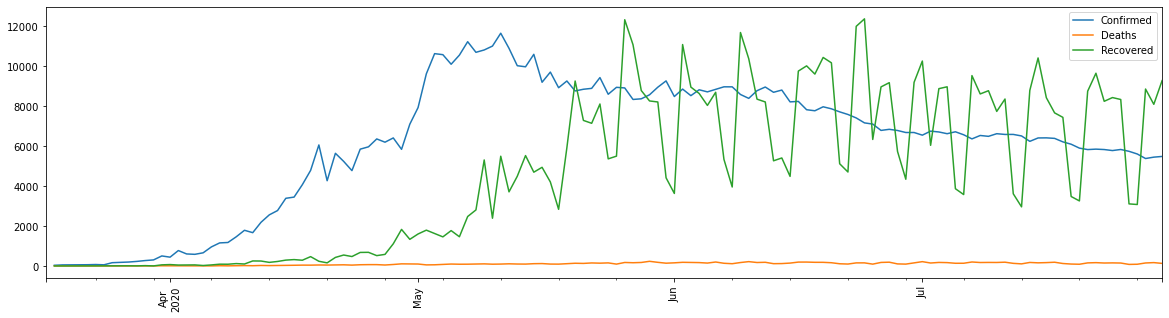

In [50]:
COVID_.loc[:,['Confirmed','Deaths','Recovered']].diff(1).plot(figsize=(20, 5))
plt.xticks(label = COVID_.index, rotation=90)

plt.show()

Видим, что скорее всего Recovery является стационарным рядом, тогда как Confirmed нестационарным. 

Перестанем смотреть и попробуем применить компьютер. Определим значение Расширеного теста Дики-Фуллера(ADF) для наших рядов Соответстующая функция доступна из https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html и позволит определить различные варианты применения теста. Импортируем модули из statsmodels и сделаем вызов теста ADF

In [15]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

Обращаемся к тесту с параметром regression='ct' - анализировать на постоянные составляющие и линейные тренды.  Квадратичных трендов я тут не вижу. Первый параметр должен содержать одномерный массив или Series

Но перед этим, напишем функцию для удобного отображения результатов теста 

In [42]:
def print_adfuller(result):
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] >= 0.05:
        print('Мы не можем отвегнуть нулевую гипотезу, временной ряд не стационарен')
    elif result[1] < 0.05:
        print('Мы можем отвергуть нулевую гипотезу, временной ряд стационарен')
    else:
        print("Непредвиденная ошибка")

Для начала рассмотрим Recovered 

$H0$ - то, что наш временной ряд не стационарен

$H1$ - временной ряд стационарен

In [36]:
DF_data = sm.tsa.stattools.adfuller(COVID_['Recovered'].values ,regression='ct')
print_adfuller(DF_data)

ADF Statistic: -3.209630
p-value: 0.082500
Critical Values:
	1%: -4.032
	5%: -3.446
	10%: -3.148
Мы не можем отвегнуть нулевую гипотезу, временной ряд не стационарен


Теперь Deaths

In [35]:
DF_data = sm.tsa.stattools.adfuller(COVID_['Deaths'].values ,regression='ct')
print_adfuller(DF_data)

ADF Statistic: -2.888875
p-value: 0.166216
Critical Values:
	1%: -4.035
	5%: -3.447
	10%: -3.149
Мы не можем отвегнуть нулевую гипотезу, временной ряд не стационарен


Ни нефть ни Recovered ни Deaths не являются стационарными . Проверим первые разности на стационарность.

In [80]:
COVID_D = COVID_.loc[:, ['Deaths']].diff(1).values
COVID_D[0,:] = 0.0

In [81]:
DF_data_r = sm.tsa.stattools.adfuller(COVID_D ,regression='ctt')
print_adfuller(DF_data_r)

ADF Statistic: -2.891823
p-value: 0.349168
Critical Values:
	1%: -4.468
	5%: -3.881
	10%: -3.583
Мы не можем отвегнуть нулевую гипотезу, временной ряд не стационарен


In [82]:
COVID_R = COVID_.loc[:, ['Recovered']].diff(1).values
COVID_R[0,:] = 0.0

In [83]:
DF_data_d = sm.tsa.stattools.adfuller(COVID_R ,regression='ctt')
print_adfuller(DF_data_d)

ADF Statistic: -2.213272
p-value: 0.723533
Critical Values:
	1%: -4.465
	5%: -3.880
	10%: -3.582
Мы не можем отвегнуть нулевую гипотезу, временной ряд не стационарен


### То же получили два не стационарных ряда. 

# Сглаживание

Будем брать значение в точке с учетом предистории и текущее значение x(i) запишем как усредненную сумму n предшествующих (x(i-n) + x(n-i+1) + ...+ x(i)) * 1/(n + 1). Это пример простой скользящей средней. 

In [193]:
b_rec = COVID_['Recovered'].values
df_r = pd.DataFrame(data = COVID_[['Recovered']])

In [194]:
b_dea = COVID_['Deaths'].values
df_d = pd.DataFrame(data = COVID_[['Deaths']])

Подготовим данные для модели

In [168]:
train_r = df_r.iloc[:-10, :]
test_r = df_r.iloc[-10:, :]

In [169]:
train_d = df_d.iloc[:-10, :]
test_d = df_d.iloc[-10:, :]

In [170]:
def plot_rolling(b_s, value):
    fig, ax = plt.subplots(3,figsize=(20, 9))
    ax[0].plot(b_s.index, b_s[value], label='исходные данные')
    ax[0].plot(b_s[value].rolling(window=N2).mean(), label="скользящая средняя");
    ax[0].plot(b_s[value].rolling(window=N2).std(), label="скользящая std (x10)");
    ax[0].legend()

    ax[1].plot(b_s.index,b_s.z_data, label="вычли тренд")
    ax[1].plot(b_s.z_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[1].plot(b_s.z_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[1].legend()

    ax[2].plot(b_s.index, b_s.zp_data, label="разности с лагом" +str(N2))
    ax[2].plot(b_s.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[2].plot(b_s.zp_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[2].legend()

    plt.title('Recovery')
    plt.show()

In [195]:
N2 = 7

## Лаговые разницы с шагом N2

In [203]:
df_r['z_data'] = (df_r['Recovered'] - df_r['Recovered'].rolling(window=N2).mean()) / df_r['Recovered'].rolling(window=N2).std()
df_r[df_r['z_data'].isna()] = 0.0
df_r['zp_data'] = df_r['z_data'] - df_r['z_data'].shift(N2)
df_r[df_r['zp_data'].isna()] = 0.0

In [205]:
df_d['z_data'] = (df_d['Deaths'] - df_d['Deaths'].rolling(window=N2).mean()) / df_d['Deaths'].rolling(window=N2).std()
df_d[df_r['z_data'].isna()] = 0.0
df_d['zp_data'] = df_d['z_data'] - df_d['z_data'].shift(N2)
df_d[df_d['zp_data'].isna()] = 0.0

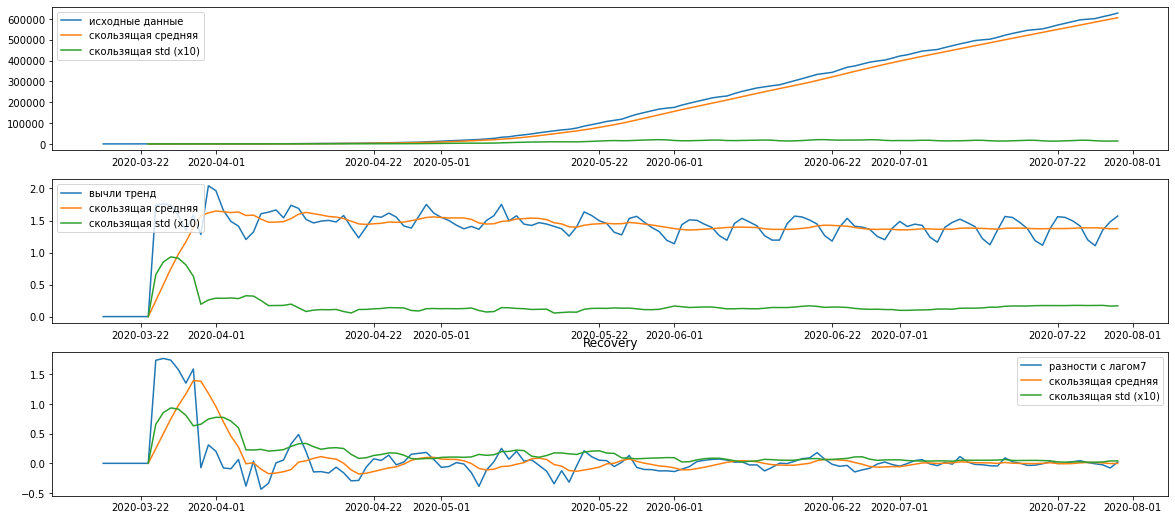

In [206]:
plot_rolling(df_r, 'Recovered')    

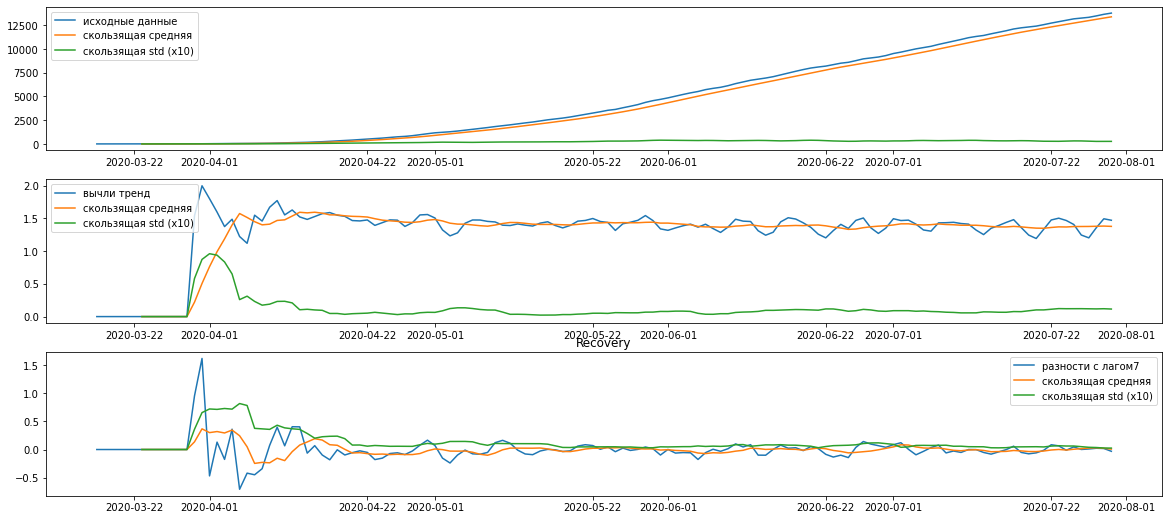

In [212]:
plot_rolling(df_d, 'Deaths')    

### Получим экспоненциальное сглаживание. 

In [208]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [213]:
df_d['exp_1'] = exponential_smoothing(df_d['Deaths'], 0.1)
df_r['exp_1'] = exponential_smoothing(df_r['Recovered'], 0.1)

Функция для построения граффика

In [215]:
def exp_plot(b_s, value):
    plt.figure(figsize=(20, 5))
    plt.plot(b_s.index, b_s[value], label='исходный ряд')
    plt.plot(b_s[value].rolling(window=N2).mean(), label="скользящие средние");

    plt.plot(b_s.index,b_s.exp_1, color = 'red', label="экспоненциальное сглаживание");
    plt.plot(b_s.index,b_s[value] - b_s.exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
    plt.xlabel('time')
    plt.ylabel('Peolple')
    plt.legend()
    plt.title(value)
    plt.show

In [216]:
df_d.head()

,Deaths,z_data,zp_data,exp_1
2020-03-17,0.0,0.0,0.0,0.0
2020-03-18,0.0,0.0,0.0,0.0
2020-03-19,0.0,0.0,0.0,0.0
2020-03-20,0.0,0.0,0.0,0.0
2020-03-21,0.0,0.0,0.0,0.0


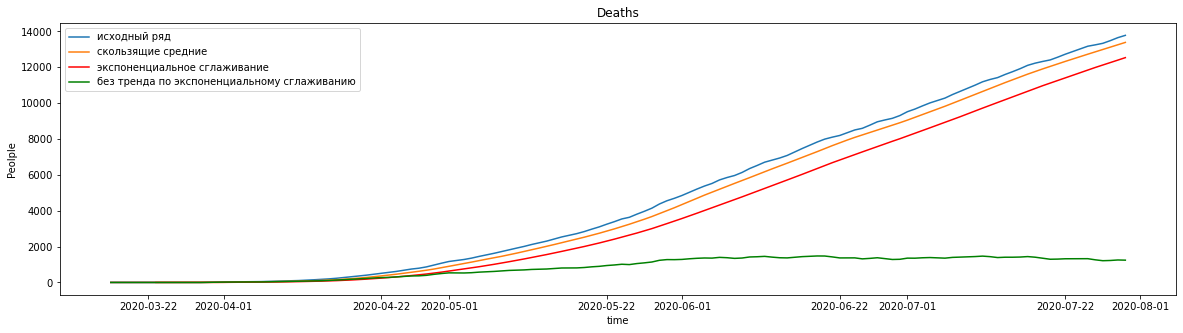

In [217]:
exp_plot(df_d, 'Deaths')

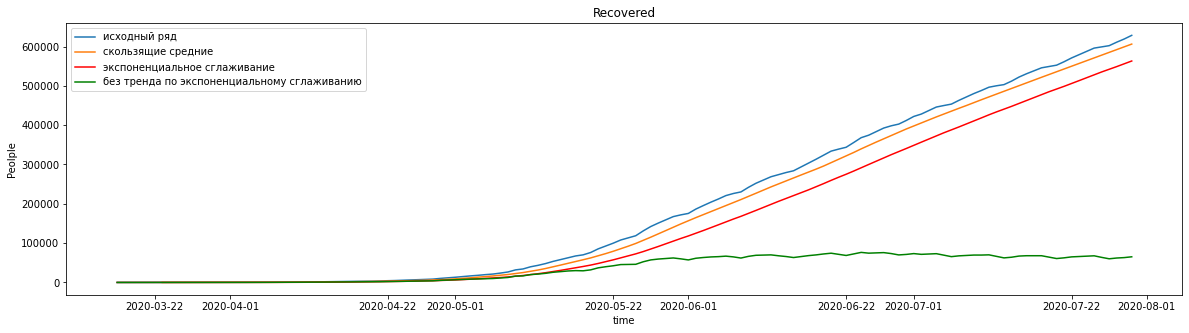

In [218]:
exp_plot(df_r, 'Recovered')

In [219]:
df_r['dif_1'] = df_r['Recovered'].diff(1)
df_d['dif_1'] = df_d['Deaths'].diff(1)

In [221]:
df_r[df_r['dif_1'].isna()] = 0.0
df_d[df_d['dif_1'].isna()] = 0.0

In [225]:
df_r['z_data_dif_1'] = (df_r['dif_1'] - df_r['dif_1'].rolling(window=N2).mean()) / df_r['dif_1'].rolling(window=N2).std()
df_r[df_r['z_data_dif_1'].isna()] = 0.0
df_r['zp_data_difp'] = df_r['z_data_dif_1'] - df_r['z_data_dif_1'].shift(N2)
df_r[df_r['zp_data_difp'].isna()] = 0.0

In [227]:
df_d['z_data_dif_1'] = (df_d['dif_1'] - df_d['dif_1'].rolling(window=N2).mean()) / df_d['dif_1'].rolling(window=N2).std()
df_d[df_d['z_data_dif_1'].isna()] = 0.0
df_d['zp_data_difp'] = df_d['z_data_dif_1'] - df_d['z_data_dif_1'].shift(N2)
df_d[df_d['zp_data_difp'].isna()] = 0.0

Сгладим первую разность

In [228]:
df_d['exp_dif_1'] = exponential_smoothing(df_d['dif_1'], 0.1)
df_r['exp_dif_1'] = exponential_smoothing(df_r['dif_1'], 0.1)

Функция для построения графика 

In [234]:
def exp_dif_plot(b_s, value, title):
    plt.figure(figsize=(20, 5))
    plt.plot(b_s.index, b_s[value], label='исходный ряд')
    plt.plot(b_s[value].rolling(window=N2).mean(), label="скользящие средние");

    plt.plot(b_s.index,b_s['exp_dif_1'], color = 'red', label="экспоненциальное сглаживание");
    plt.plot(b_s.index, b_s['dif_1'] - b_s['exp_dif_1'], color = 'green', label="без тренда по экспоненциальному сглаживанию");
    plt.xlabel('time')
    plt.ylabel('Peolple')
    plt.legend()
    plt.title(title)
    plt.show

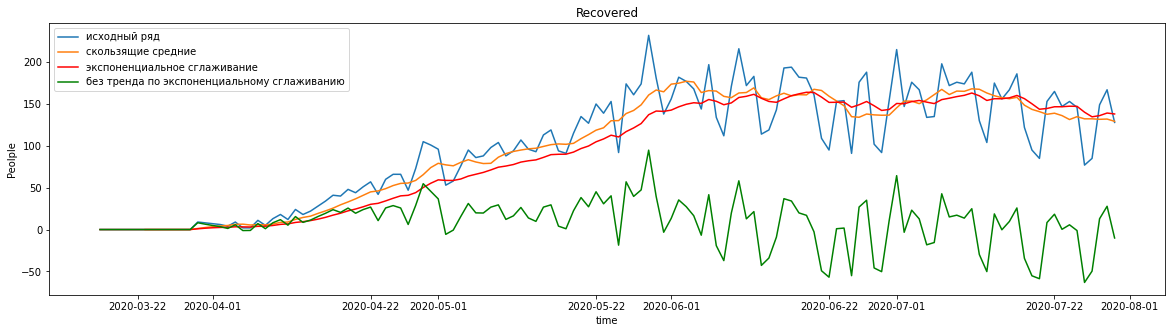

In [235]:
exp_dif_plot(df_d, 'dif_1', 'Recovered')

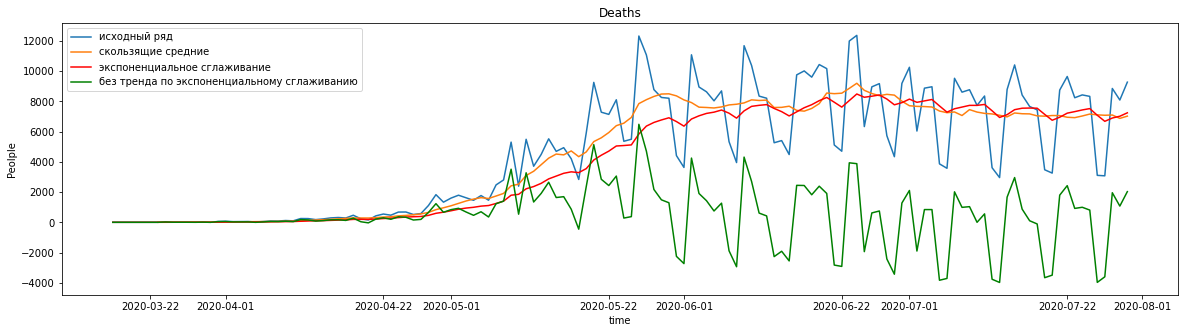

In [236]:
exp_dif_plot(df_r, 'dif_1', 'Deaths')

In [254]:
def f_by_index(data):
    data['date'] = data.index
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['dayofmonth'] = data['date'].dt.day
    data['quarter'] = data['date'].dt.quarter
    data['dayofyear'] = data['date'].dt.dayofyear
    data['weekofyear'] = data['date'].dt.weekofyear
    data['dayofweek'] = data['date'].dt.dayofweek
    data['hour'] = data['date'].dt.hour
    data['weekend'] = np.where(data.dayofweek > 5, '1', '0')
    
    data = data.drop(['date'], axis=1)    

    return data

In [256]:
df_r = f_by_index(df_r)

In [258]:
df_d = f_by_index(df_d)

In [260]:
DF_data_d = sm.tsa.stattools.adfuller(df_r['exp_dif_1'] ,regression='ctt')
print_adfuller(DF_data_d)

ADF Statistic: -3.115526
p-value: 0.243156
Critical Values:
	1%: -4.464
	5%: -3.879
	10%: -3.582
Мы не можем отвегнуть нулевую гипотезу, временной ряд не стационарен


In [261]:
DF_data_d = sm.tsa.stattools.adfuller(df_d['exp_dif_1'] ,regression='ctt')
print_adfuller(DF_data_d)

ADF Statistic: -2.567185
p-value: 0.530716
Critical Values:
	1%: -4.469
	5%: -3.882
	10%: -3.584
Мы не можем отвегнуть нулевую гипотезу, временной ряд не стационарен


# Применим преобразование Яо Джонсона 

In [268]:
from scipy import stats
from sklearn.preprocessing import PowerTransformer

In [286]:
def yao_jonson(data, features):
    for feature in features:
        data[feature  + '_yeojohnson'], _ = stats.yeojohnson(data[feature], lmbda=None) 
    return data

In [266]:
features = ['z_data', 'zp_data', 'exp_1', 'dif_1', 'z_data_dif_1', 'zp_data_difp', 'exp_dif_1']

In [287]:
df_r = yao_jonson(df_r, features)

In [289]:
df_d = yao_jonson(df_d, features)

# Добавим фичи по истории

In [ ]:
df_r.index.name = 'Дата'

In [481]:
df_r['t'] = 0.0
df_r.iloc[1: , -3]=df_r.iloc[:-1 , 0].values
df_r['t1']=0.0
df_r.iloc[2:, -2]=df_r.iloc[:-2,0].values
df_r['t2']=0.0
df_r.iloc[3:, -1]=df_r.iloc[:-3,0].values
df_r.fillna(0)

,Recovered,z_data,zp_data,exp_1,dif_1,z_data_dif_1,zp_data_difp,exp_dif_1,year,month,...,z_data_yeojohnson,zp_data_yeojohnson,exp_1_yeojohnson,dif_1_yeojohnson,z_data_dif_1_yeojohnson,zp_data_difp_yeojohnson,exp_dif_1_yeojohnson,t,t1,t2
Дата,,,,,,,,,,,,,,,,,,,,,
2020-03-17,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,2020,3,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2020-03-18,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,2020,3,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2020-03-19,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,2020,3,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2020-03-20,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,2020,3,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2020-03-21,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,2020,3,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-26,599172.0,596064.0,587728.0,579295.0,3108.0,-1.469197,-0.191762,7085.427381,2020,7,...,6.294763,0.012502,53.344536,45.764552,-1.305308,-0.189128,52.592763,596064.0,587728.0,579295.0
2020-07-27,602249.0,599172.0,596064.0,587728.0,3077.0,-1.448314,-0.039961,6684.584643,2020,7,...,5.213775,-0.007335,53.475147,45.592653,-1.288347,-0.039840,51.542094,599172.0,596064.0,587728.0
2020-07-28,611109.0,602249.0,599172.0,596064.0,8860.0,0.632624,0.007081,6902.126179,2020,7,...,8.392943,-0.025736,53.608627,67.548241,0.672962,0.007085,52.117402,602249.0,599172.0,596064.0


### Начнем делать модель 

In [483]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score


In [484]:
scl =StandardScaler()
scly =StandardScaler()

# Построим модель для Recovery

Разделим данные

In [506]:
# сделаем примеры и модель 
def split_data_b(data, split_date ):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [549]:
train_b, test_b = split_data_b( df_r, '10-07-2020 00:00:00')

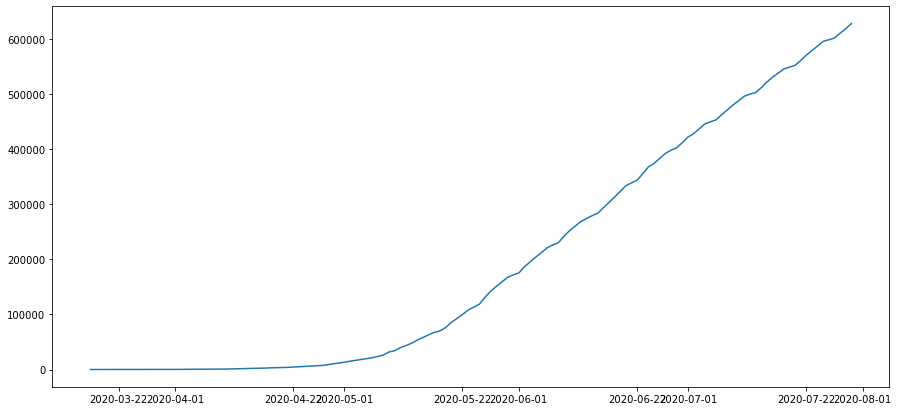

In [525]:
plt.figure( figsize=( 15, 7 ))
plt.plot(df_r.index, df_r.Recovered)

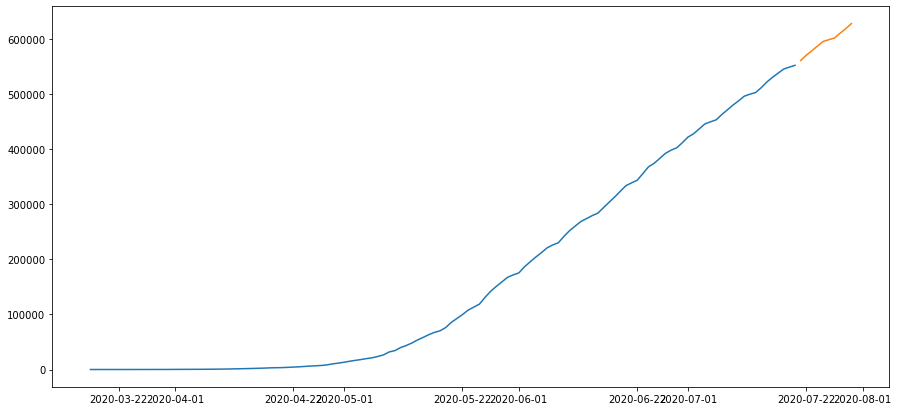

In [526]:
plt.figure( figsize=( 15, 7 ))
plt.plot(train_b.index, train_b.Recovered)
plt.plot(test_b.index, test_b.Recovered)

In [552]:
X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df_r.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df_r.columns[0]].values[1:]

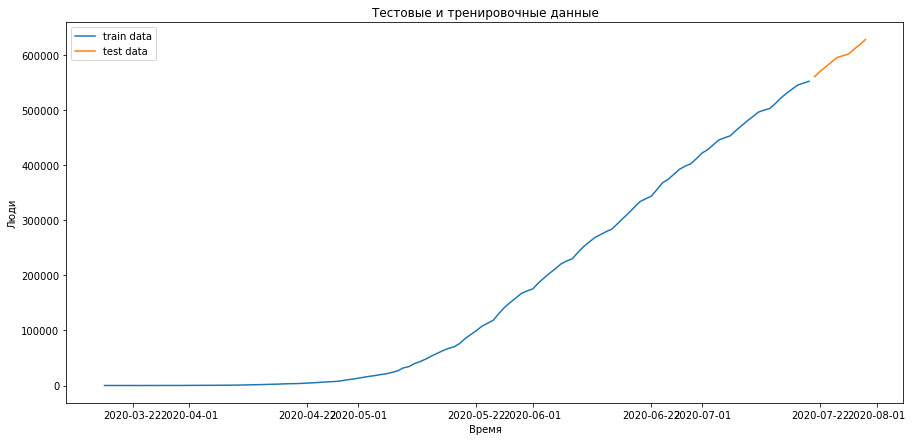

In [528]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Люди')
plt.plot(train_b.index.get_level_values('Дата'),train_b[df_r.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Дата'),test_b[df_r.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

Объекты моделей 

In [529]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [530]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

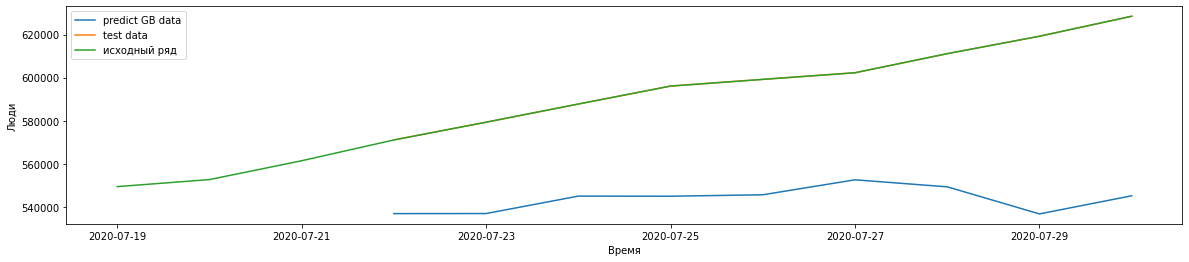

In [537]:
plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Люди')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(df_r.loc['19-07-2020 00:00:00':].index, df_r.loc['19-07-2020 00:00:00':]['Recovered'], label='исходный ряд')

plt.legend()
plt.show()

In [538]:
er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

ошибка градиентного бустинга :   9.228702822197846 %


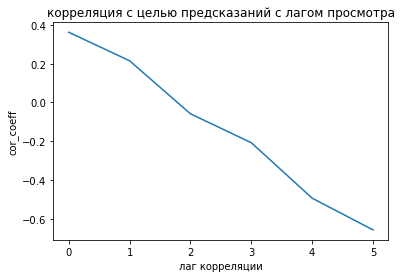

In [539]:
lag=5
p_cor=[np.corrcoef( y_test_b, X_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_b[:-(i+1)], X_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

In [555]:
h=5
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df_r.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df_r.columns[0]].values[h:]

In [556]:
X_test_b.shape[0]

0

In [551]:
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

ValueError: Found array with 0 sample(s) (shape=(0, 27)) while a minimum of 1 is required.

In [544]:




plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(df_r.loc['2020-10-07':].index, df_r.loc['2020-10-07':]['Значение'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

KeyError: 'Deaths'